In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
import kagglehub

path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /Users/stevezhu/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [3]:
dataset_path = f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(dataset_path)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [7]:
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features.remove('Churn')

In [8]:
ohe = OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore')
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

In [9]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [10]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

print(f"Resampled X_train shape: {X_train_res.shape}")
print(f"Resampled y_train shape: {y_train_res.shape}")

Resampled X_train shape: (8260, 5654)
Resampled y_train shape: (8260,)


In [12]:
X_train_res = pd.DataFrame(
    X_train_res, 
    columns=preprocessor.get_feature_names_out()
)

In [13]:
X_test_preprocessed = preprocessor.transform(X_test)
X_test_preprocessed = pd.DataFrame(
    X_test_preprocessed, 
    columns=preprocessor.get_feature_names_out()
)

/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [14]:
print("Original columns:", X_train.columns)
print("Transformed columns:", preprocessor.get_feature_names_out())

Original columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Transformed columns: ['num__SeniorCitizen' 'num__tenure' 'num__MonthlyCharges' ...
 'cat__PaymentMethod_Credit card (automatic)'
 'cat__PaymentMethod_Electronic check' 'cat__PaymentMethod_Mailed check']


In [15]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [16]:
results = {}

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82      1033
           1       0.53      0.72      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407



/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


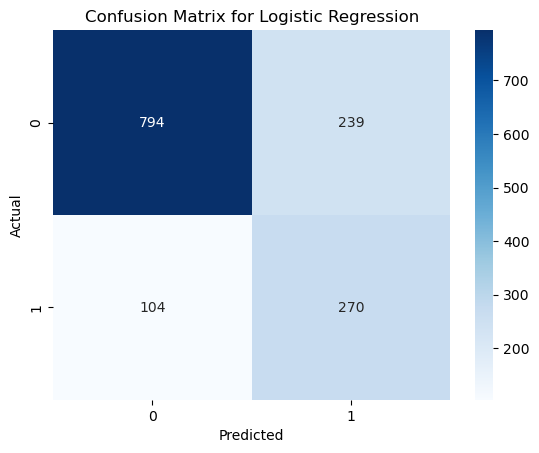

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


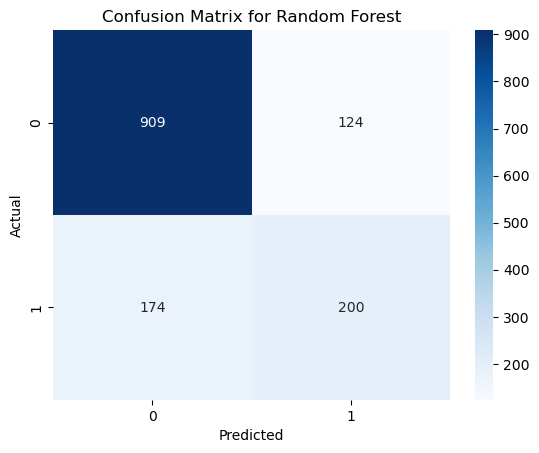

/Users/stevezhu/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [11:16:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1033
           1       0.55      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.76      0.76      0.76      1407



/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


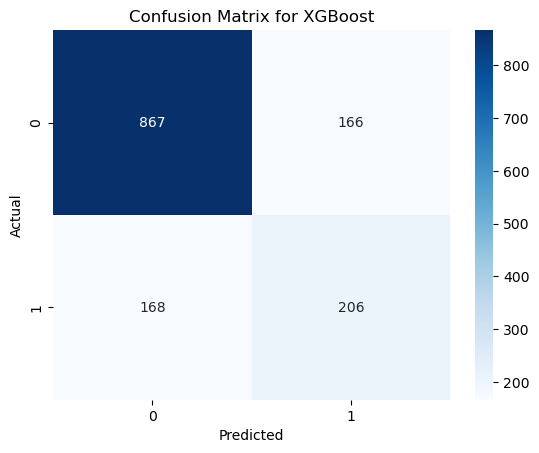

In [17]:
for model_name, model in models.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    accuracy = np.mean(y_pred == y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    }
    
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [18]:
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Precision    Recall  F1-Score   ROC AUC
Logistic Regression  0.756219   0.530452  0.721925  0.611552  0.831393
Random Forest        0.788202   0.617284  0.534759  0.573066  0.822855
XGBoost              0.762615   0.553763  0.550802  0.552279  0.813247


In [19]:
results_df.to_csv('model_results.csv', index=True)

In [20]:
print("Original columns in X_train:", X_train.columns)
print("Transformed columns from preprocessor:", preprocessor.get_feature_names_out())
print("Columns in X_train_res:", X_train_res.columns if isinstance(X_train_res, pd.DataFrame) else "Not a DataFrame")

Original columns in X_train: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')
Transformed columns from preprocessor: ['num__SeniorCitizen' 'num__tenure' 'num__MonthlyCharges' ...
 'cat__PaymentMethod_Credit card (automatic)'
 'cat__PaymentMethod_Electronic check' 'cat__PaymentMethod_Mailed check']
Columns in X_train_res: Index(['num__SeniorCitizen', 'num__tenure', 'num__MonthlyCharges',
       'num__TotalCharges', 'cat__customerID_0003-MKNFE',
       'cat__customerID_0004-TLHLJ', 'cat__customerID_0011-IGKFF',
       'cat__customerID_0013-EXCHZ', 'cat__customerID_0013-MHZWF',
       'cat__customerID_0013-SMEOE',
       ...
       'cat__StreamingTV_No internet service', 

In [21]:
best_model_name = max(results, key=lambda x: results[x]['ROC AUC'])
best_model = models[best_model_name]

pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', best_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression())])

In [22]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

/Users/stevezhu/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


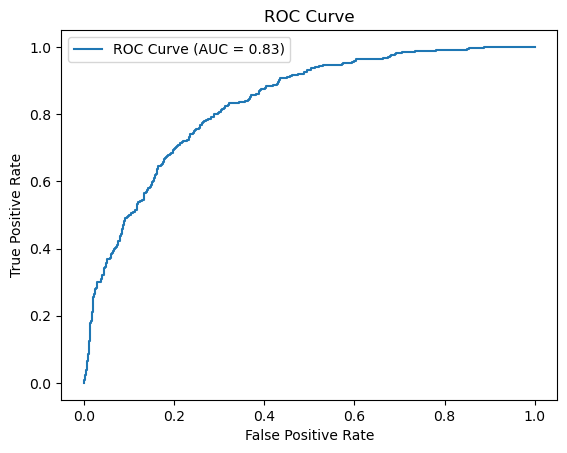

In [23]:
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()